# Processor

This python notebook consists of a set of functions that take a JSON input from the `scraper` tool, and get the data into a format that we can serve on the final website. 

## JSON to CSV

As our input data is currently formatted in JSON, we want to convert that to CSV so we can work with entire columns, and eventually push to a database like PostgreSQL.

To avoid corrupting the original data that was collected, place a copy of the data in the convenience folder `./_raw_json` in this directory, and only modify this copied data as you work with the modules in this notebook.

The following block of code will go through all the JSON files in the specified directory, flatten them, convert them into CSV's, and save them all to disk in the `./_raw_csv` directory.

**NOTE**: This is the only part of the process that's somewhat hardcoded. In order to combine the JSON into a single CSV, the column names have to be consistently named, and its easier to acheive this by editing the JSON's before saving as CSV's.

In [29]:
%load_ext autoreload
%autoreload 2

import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from flatten_json import flatten
from tqdm import tqdm

JSON_DIR = './_raw_json'
CSV_DIR = './_raw_csv'
CSV_COMBINED = 'combined.csv'
CSV_FINAL = 'final.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Helper Functions

In [30]:
def delete_keys_from_dict(d, to_delete):
    if isinstance(to_delete, str):
        to_delete = [to_delete]
    if isinstance(d, dict):
        for single_to_delete in set(to_delete):
            if single_to_delete in d:
                del d[single_to_delete]
        for k, v in d.items():
            delete_keys_from_dict(v, to_delete)
    elif isinstance(d, list):
        for i in d:
            delete_keys_from_dict(i, to_delete)

#### Run

In [31]:
for subdir, dirs, files in os.walk(JSON_DIR):
    for filename in tqdm(files):
        if ".json" in filename:
            year = subdir.split("/")[-1]
            with open(os.path.join(subdir, filename), 'r', encoding='utf-8') as f:
                data = json.load(f)

                # 1. First globally delete all the keys that we don't want.
                delete_keys_from_dict(data, ['__typename', 'best_datasheet', 'best_image', 'manufacturer_url'])

                for result in data['data']['search']['results']:
                    # 2. Within the JSON, flatten the `specs` array from 
                    #    'specs': [{'attribute': {'id': '548',
                    #                             'name': 'Capacitance' 
                    #                             'shortname': 'capacitance'
                    #                             '__typename': 'Attribute'
                    #                            },
                    #               'display_value': '100 nF'
                    #              },
                    #              { ... },
                    #              { ... },
                    #              ...
                    #             ]
                    #    to
                    #    'specs': {'capacitance': {'display_value': '100 nF', 'id': '548'},
                    #              'case_package': {'display_value': 'Radial', 'id': '842'},
                    #              'depth': {'display_value': '8 mm', 'id': '291'},
                    #              ...
                    #             }    
                    #    and remove some fields that we don't want to include.
                    spec_json = {}
                    for spec in result['part']['specs']:
                        title = spec['attribute']['shortname']
                        spec['attribute']['display_value'] = spec['display_value']
                        spec = spec['attribute']
                        del spec['shortname']
                        del spec['name']
                        spec_json[title] = spec
                    result['part']['specs'] = spec_json

                    # 3. Remove specific parts of the JSON that we don't want (duplicate fields, etc).
                    del result['part']['_cache_id']
                    del result['part']['descriptions']
                    del result['part']['counts']
                    
                    # 4. Add the year of the component based on the subdirectory name.
                    result['year'] = year

                # 5. Run the `flatten` function on each of the parts, place it in a list, and convert 
                #    to a Pandas DF.
                flat = [flatten(d) for d in data['data']['search']['results']]

                df = pd.DataFrame(flat, dtype ='str')
                if not os.path.exists(f"{CSV_DIR}/{year}"):
                    os.mkdir(f"{CSV_DIR}/{year}")
                df.to_csv(f"{CSV_DIR}/{year}/{filename.split('.')[0]}.csv", index=False)


100%|████| 5/5 [01:29<00:00, 17.81s/it]


#### Combine

In [32]:
filenames = []
for subdir, dirs, files in os.walk(CSV_DIR):
    for filename in tqdm(files):
        if "all" not in filename and ".csv" in filename:
            filenames.append(os.path.join(subdir, filename))


df = pd.concat(map(pd.read_csv, filenames), ignore_index=True)
df = df.astype(str)
df.to_csv(f"{CSV_DIR}/{CSV_COMBINED}", index=False)

100%|█| 4/4 [00:00<00:00, 95325.09it/s]
/var/folders/21/pp5p0yss3xq_1z5gvfm0shgh0000gn/T/ipykernel_47629/4027898012.py:8: DtypeWarning: Columns (83,89,91,100,104,108,110,116,118,120,122,124,126,128,130,132,134,136,142,144,146,148,150,154,156,158,160,162,164,166,168,170,172,174,176,178,180,182,184,186,188) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(map(pd.read_csv, filenames), ignore_index=True)
/var/folders/21/pp5p0yss3xq_1z5gvfm0shgh0000gn/T/ipykernel_47629/4027898012.py:8: DtypeWarning: Columns (14,20,22,24,30,32,36,38,40,46,50,52,54,62,64,66,68,74,77,79,81,83,85,87,89,91,93,95,97,99,101,103,105,107,109,111,113,115,117,119,122,130,132,134,136,140,142,144,146,148,150,152,154,156,158,160,162,164,168,170,172,174,178,180,182,184,186,188,190,192,194,196,198,200,202,204,206,208,210,212,214,216,218,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,252,254) have mixed types. Specify dtype option on import or set low_memory=False.
  df

## CSV Postprocessing

In this step, we want to take the combined CSV that we generated in the previous step and format it into the final format that we will upload to the PostgreSQL database.

We will use a modular approach. For each step of updating the CSV, we will implement a function that takes in a pandas dataframe and outputs another pandas dataframe in the desired format. 

In [40]:
df = pd.read_csv(f'{CSV_DIR}/{CSV_COMBINED}', index_col=False)

/var/folders/21/pp5p0yss3xq_1z5gvfm0shgh0000gn/T/ipykernel_47629/3219921549.py:1: DtypeWarning: Columns (14,16,18,24,26,28,30,36,38,40,44,46,48,50,54,58,61,63,65,67,71,73,75,79,81,83,85,87,89,91,93,95,97,100,102,104,108,110,116,118,120,122,124,126,128,130,132,134,136,142,144,146,148,150,154,156,158,160,162,164,166,168,170,172,174,176,178,180,182,184,186,188,190,192,194,196,198,200,202,204,206,208,210,214,218,220,222,224,226,228,230,232,236,238,240,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,274,276,278,280,282,284,286,290,292,294,296,298,300,302,304,306,310,312,314,316,318) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{CSV_DIR}/{CSV_COMBINED}', index_col=False)


In [41]:
string_to_float_cols = [
    'part_specs_tolerance_display_value', 
    'part_specs_temperaturecoefficient_display_value', 
    'part_specs_maxjunctiontemperature_display_value', 
    'part_specs_maxoperatingtemperature_display_value', 
    'part_specs_minoperatingtemperature_display_value', 
    'part_specs_dissipationfactor_display_value', 
    'part_specs_failurerate_display_value', 
    'part_specs_frequencytolerance_display_value', 
    'part_specs_qfactor_display_value', 
    'part_specs_frequencystability_display_value', 
    'part_specs_accuracy_display_value', 
    'part_specs_speedgrade_display_value', 
    'part_specs_inductancetolerance_display_value', 
    'part_specs_ambienttemperaturerangehigh_display_value'
]

string_to_int_cols = [
    'part_specs_numberofpins_display_value', 
    'part_specs_life_hours__display_value', 
    'part_specs_life_cycles__display_value', 
    'part_specs_numberofcapacitors_display_value', 
]

string_to_base_float_cols = [
    'part_specs_capacitance_display_value', 
    'part_specs_depth_display_value', 
    'part_specs_height_display_value', 
    'part_specs_height_seated_max__display_value', 
    'part_specs_length_display_value', 
    'part_specs_voltage_display_value', 
    'part_specs_voltagerating_display_value', 
    'part_specs_voltagerating_ac__display_value', 
    'part_specs_voltagerating_dc__display_value', 
    'part_specs_width_display_value', 
    'part_specs_weight_display_value', 
    'part_specs_insulationresistance_display_value', 
    'part_specs_diameter_display_value', 
    'part_specs_thickness_display_value', 
    'part_specs_esr_equivalentseriesresistance__display_value', 
    'part_specs_resistance_display_value', 
    'part_specs_dcresistance_dcr__display_value', 
    'part_specs_inductance_display_value', 
    'part_specs_maxdccurrent_display_value', 
    'part_specs_powerrating_display_value', 
    'part_specs_seriesresistance_display_value', 
    'part_specs_currentrating_display_value', 
    'part_specs_characterheight_display_value', 
    'part_specs_ripplecurrent_display_value',
    'part_specs_maxlength_display_value', 
    'part_specs_maxthickness_display_value', 
    'part_specs_maxwidth_display_value', 
    'part_specs_minlength_display_value', 
    'part_specs_minthickness_display_value', 
    'part_specs_minwidth_display_value', 
    'part_specs_insidediameter_display_value', 
    'part_specs_selfresonantfrequency_display_value', 
    'part_specs_current_display_value', 
    'part_specs_maxcurrentrating_display_value', 
    'part_specs_maxvoltagerating_dc__display_value', 
    'part_specs_maxfrequency_display_value', 
    'part_specs_leakagecurrent_display_value', 
    'part_specs_testfrequency_display_value', 
    'part_specs_ripplecurrent_ac__display_value', 
    'part_specs_impedance_display_value', 
    'part_specs_outsidediameter_display_value', 
    'part_specs_workingvoltage_display_value', 
    'part_specs_frequency_display_value'
]

In [42]:
%aimport compute
%aimport categories

In [43]:
df = compute.spec_string_to_float(df, cols=string_to_float_cols)
df = compute.spec_string_to_int(df, cols=string_to_int_cols)
df = compute.spec_string_to_base_float(df, cols=string_to_base_float_cols) # convert string to X

df = compute.classify_ceramic(df) # 
df = compute.classify_dielectric(df)

df = compute.process_category(df)
df = compute.process_manufacturer(df)
df = compute.process_mpn(df)
df = compute.process_voltage(df)
df = compute.process_current(df)
df = compute.process_capacitance(df)
df = compute.process_esr(df)
df = compute.process_esr_frequency(df)
df = compute.process_price(df)

df = compute.compute_volume(df)
df = compute.compute_mass(df)
df = compute.compute_energy(df)
df = compute.compute_rated_power(df)
df = compute.compute_gravimetric_energy_density(df)
df = compute.compute_volumetric_energy_density(df)
df = compute.compute_gravimetric_power_density(df)
df = compute.compute_volumetric_power_density(df)
df = compute.compute_energy_per_cost(df)

df = compute.drop_all_except(df, cols=list(categories.column_map.values()))

In [44]:
df.to_csv(f'{CSV_DIR}/{CSV_FINAL}', index=False)

## Deploy

In this step, we want to take the final CSV that we generated, and actually upload it to our PostgreSQL database. We will use a package called (https://pypi.org/project/postgres-csv-uploader/) that was developed for this project in order to both infer the types for each of the columns in the CSV, create the necessary table schema, and then handle the upload process for the actual contents to the database.

In [45]:
from postgres_csv_uploader.uploader import PostgresCSVUploader
import psycopg2 as ps

In [46]:
host = "ec2-34-233-115-14.compute-1.amazonaws.com"
port = 5432
database = "dfu56m15dkhh46"
user = "pgyrjmstmyerfk"
password = "228fcbba14e9d2bf362fcaa29cabe1106cc8dba00605f45ee25e810194309fd4"

conn = ps.connect(
    host=host,
    user=user,
    password=password,
    port=port,
    database=database
)

uploader = PostgresCSVUploader(conn)
uploader.upload(
    f'{CSV_DIR}/{CSV_FINAL}',
    CSV_FINAL.split('.')[0]
)

/opt/homebrew/lib/python3.9/site-packages/postgres_csv_uploader/uploader.py:131: DtypeWarning: Columns (3,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, parse_dates=datetime_cols)


## Visualizations

In [100]:
data_viz = pd.read_csv("final.csv", index_col=False)

/var/folders/21/pp5p0yss3xq_1z5gvfm0shgh0000gn/T/ipykernel_68919/830189037.py:1: DtypeWarning: Columns (14,18,34,36,38,42,44,60,62,64,68,75,79,83,85,89,91,93,97,99,102,104,120,122,134,139,145,151,154,156,158,165,169,171,173,189,200,204,206,210,212,214,244,252,258,263,267,269,272,274,279) have mixed types. Specify dtype option on import or set low_memory=False.
  data_viz = pd.read_csv("final.csv", index_col=False)


### Capacitance vs. Rated DC Voltage

<AxesSubplot:title={'center':'Capacitance vs. Rated DC Voltage'}, xlabel='voltage', ylabel='capacitance'>

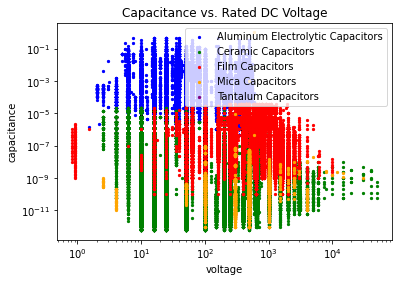

In [101]:
x = "voltage"
y = "capacitance"
one = data_viz.loc[data_viz["part_category_id"] == 6331].plot.scatter(x=x, y=y, label="Aluminum Electrolytic Capacitors", loglog=True, color="Blue", s=5, title='Capacitance vs. Rated DC Voltage') 
data_viz.loc[data_viz["part_category_id"] == 6332].plot.scatter(x=x, y=y, label="Ceramic Capacitors", loglog=True, ax=one, color="Green", s=5)
data_viz.loc[data_viz["part_category_id"] == 6333].plot.scatter(x=x, y=y, label="Film Capacitors", loglog=True, ax=one, color="Red", s=5)
data_viz.loc[data_viz["part_category_id"] == 6334].plot.scatter(x=x, y=y, label="Mica Capacitors", loglog=True, ax=one, color="Orange", s=5)
data_viz.loc[data_viz["part_category_id"] == 6336].plot.scatter(x=x, y=y, label="Tantalum Capacitors", loglog=True, ax=one, color="Purple", s=5)

### Rated Voltage vs. Volumetric Energy Density

<AxesSubplot:title={'center':'Rated Voltage vs. Volumetric Energy Density'}, xlabel='voltage', ylabel='volumetric_energy_density'>

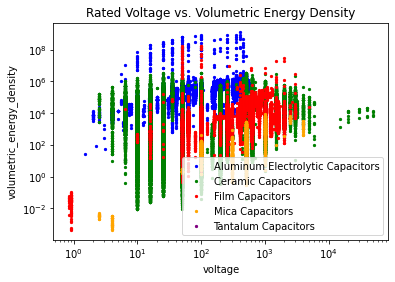

In [102]:
x = "voltage"
y = "volumetric_energy_density"
one = data_viz.loc[data_viz["part_category_id"] == 6331].plot.scatter(x=x, y=y, label="Aluminum Electrolytic Capacitors", loglog=True, color="Blue", s=5, title='Rated Voltage vs. Volumetric Energy Density') 
data_viz.loc[data_viz["part_category_id"] == 6332].plot.scatter(x=x, y=y, label="Ceramic Capacitors", loglog=True, ax=one, color="Green", s=5)
data_viz.loc[data_viz["part_category_id"] == 6333].plot.scatter(x=x, y=y, label="Film Capacitors", loglog=True, ax=one, color="Red", s=5)
data_viz.loc[data_viz["part_category_id"] == 6334].plot.scatter(x=x, y=y, label="Mica Capacitors", loglog=True, ax=one, color="Orange", s=5)
data_viz.loc[data_viz["part_category_id"] == 6336].plot.scatter(x=x, y=y, label="Tantalum Capacitors", loglog=True, ax=one, color="Purple", s=5)

### Rated Voltage vs. Gravimetric Energy Density

<AxesSubplot:title={'center':'Rated Voltage vs. Gravimetric Energy Density'}, xlabel='voltage', ylabel='gravimetric_energy_density'>

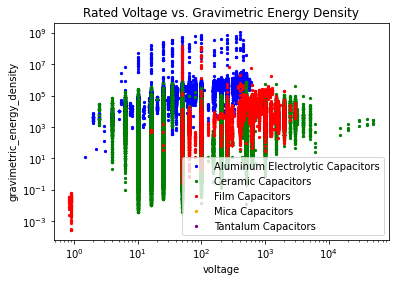

In [103]:
x = "voltage"
y = "gravimetric_energy_density"
one = data_viz.loc[data_viz["part_category_id"] == 6331].plot.scatter(x=x, y=y, label="Aluminum Electrolytic Capacitors", loglog=True, color="Blue", s=5, title='Rated Voltage vs. Gravimetric Energy Density') 
data_viz.loc[data_viz["part_category_id"] == 6332].plot.scatter(x=x, y=y, label="Ceramic Capacitors", loglog=True, ax=one, color="Green", s=5)
data_viz.loc[data_viz["part_category_id"] == 6333].plot.scatter(x=x, y=y, label="Film Capacitors", loglog=True, ax=one, color="Red", s=5)
data_viz.loc[data_viz["part_category_id"] == 6334].plot.scatter(x=x, y=y, label="Mica Capacitors", loglog=True, ax=one, color="Orange", s=5)
data_viz.loc[data_viz["part_category_id"] == 6336].plot.scatter(x=x, y=y, label="Tantalum Capacitors", loglog=True, ax=one, color="Purple", s=5)

### Rated Voltage vs. Energy per Cost

<AxesSubplot:title={'center':'Rated Voltage vs. Energy per Cost'}, xlabel='voltage', ylabel='energy_per_cost'>

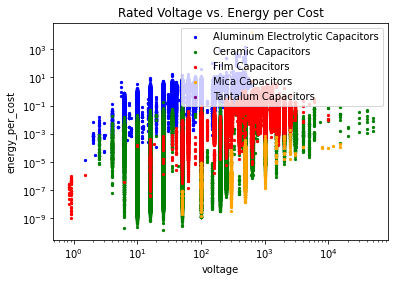

In [104]:
x = "voltage"
y = "energy_per_cost"
one = data_viz.loc[data_viz["part_category_id"] == 6331].plot.scatter(x=x, y=y, label="Aluminum Electrolytic Capacitors", loglog=True, color="Blue", s=5, title='Rated Voltage vs. Energy per Cost') 
data_viz.loc[data_viz["part_category_id"] == 6332].plot.scatter(x=x, y=y, label="Ceramic Capacitors", loglog=True, ax=one, color="Green", s=5)
data_viz.loc[data_viz["part_category_id"] == 6333].plot.scatter(x=x, y=y, label="Film Capacitors", loglog=True, ax=one, color="Red", s=5)
data_viz.loc[data_viz["part_category_id"] == 6334].plot.scatter(x=x, y=y, label="Mica Capacitors", loglog=True, ax=one, color="Orange", s=5)
data_viz.loc[data_viz["part_category_id"] == 6336].plot.scatter(x=x, y=y, label="Tantalum Capacitors", loglog=True, ax=one, color="Purple", s=5)

### Volumetric Energy Density vs Power

<AxesSubplot:title={'center':'Volumetric Energy Density vs Power'}, xlabel='volumetric_energy_density', ylabel='power'>

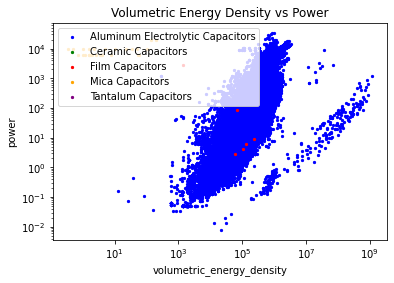

In [105]:
x = "volumetric_energy_density"
y = "power"
one = data_viz.loc[data_viz["part_category_id"] == 6331].plot.scatter(x=x, y=y, label="Aluminum Electrolytic Capacitors", loglog=True, color="Blue", s=5, title='Volumetric Energy Density vs Power') 
data_viz.loc[data_viz["part_category_id"] == 6332].plot.scatter(x=x, y=y, label="Ceramic Capacitors", loglog=True, ax=one, color="Green", s=5)
data_viz.loc[data_viz["part_category_id"] == 6333].plot.scatter(x=x, y=y, label="Film Capacitors", loglog=True, ax=one, color="Red", s=5)
data_viz.loc[data_viz["part_category_id"] == 6334].plot.scatter(x=x, y=y, label="Mica Capacitors", loglog=True, ax=one, color="Orange", s=5)
data_viz.loc[data_viz["part_category_id"] == 6336].plot.scatter(x=x, y=y, label="Tantalum Capacitors", loglog=True, ax=one, color="Purple", s=5)

### Volumetric Energy Density vs Volumetric Power Density

<AxesSubplot:title={'center':'Energy Density vs Power Density'}, xlabel='volumetric_energy_density', ylabel='volumetric_power_density'>

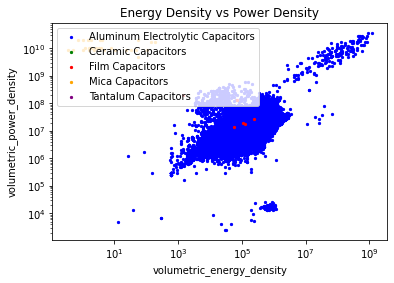

In [116]:
x = "volumetric_energy_density"
y = "volumetric_power_density"
one = data_viz.loc[data_viz["part_category_id"] == 6331].plot.scatter(x=x, y=y, label="Aluminum Electrolytic Capacitors", loglog=True, color="Blue", s=5, title='Volumetric Energy Density vs Volumetric Power Density') 
data_viz.loc[data_viz["part_category_id"] == 6332].plot.scatter(x=x, y=y, label="Ceramic Capacitors", loglog=True, ax=one, color="Green", s=5)
data_viz.loc[data_viz["part_category_id"] == 6333].plot.scatter(x=x, y=y, label="Film Capacitors", loglog=True, ax=one, color="Red", s=5)
data_viz.loc[data_viz["part_category_id"] == 6334].plot.scatter(x=x, y=y, label="Mica Capacitors", loglog=True, ax=one, color="Orange", s=5)
data_viz.loc[data_viz["part_category_id"] == 6336].plot.scatter(x=x, y=y, label="Tantalum Capacitors", loglog=True, ax=one, color="Purple", s=5)

### Volumetric Energy Density vs Gravimetric Power Density

<AxesSubplot:title={'center':'Volumetric Energy Density vs Gravimetric Power Density'}, xlabel='volumetric_energy_density', ylabel='gravimetric_power_density'>

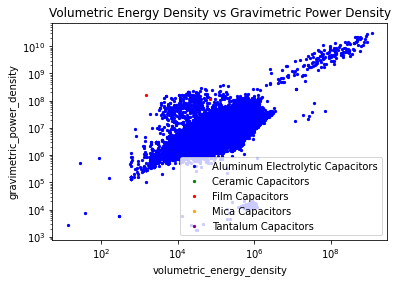

In [117]:
x = "volumetric_energy_density"
y = "gravimetric_power_density"
one = data_viz.loc[data_viz["part_category_id"] == 6331].plot.scatter(x=x, y=y, label="Aluminum Electrolytic Capacitors", loglog=True, color="Blue", s=5, title='Volumetric Energy Density vs Gravimetric Power Density') 
data_viz.loc[data_viz["part_category_id"] == 6332].plot.scatter(x=x, y=y, label="Ceramic Capacitors", loglog=True, ax=one, color="Green", s=5)
data_viz.loc[data_viz["part_category_id"] == 6333].plot.scatter(x=x, y=y, label="Film Capacitors", loglog=True, ax=one, color="Red", s=5)
data_viz.loc[data_viz["part_category_id"] == 6334].plot.scatter(x=x, y=y, label="Mica Capacitors", loglog=True, ax=one, color="Orange", s=5)
data_viz.loc[data_viz["part_category_id"] == 6336].plot.scatter(x=x, y=y, label="Tantalum Capacitors", loglog=True, ax=one, color="Purple", s=5)

<AxesSubplot:title={'center':'Volumetric Energy Density vs Power'}, xlabel='capacitance', ylabel='mass'>

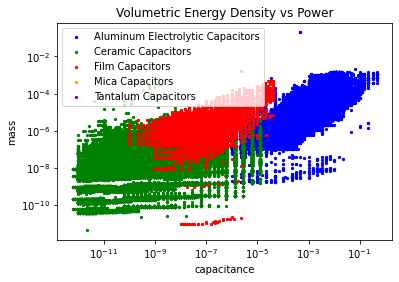

In [107]:
x = "capacitance"
y = "mass"
one = data_viz.loc[data_viz["part_category_id"] == 6331].plot.scatter(x=x, y=y, label="Aluminum Electrolytic Capacitors", loglog=True, color="Blue", s=5, title='Volumetric Energy Density vs Power') 
data_viz.loc[data_viz["part_category_id"] == 6332].plot.scatter(x=x, y=y, label="Ceramic Capacitors", loglog=True, ax=one, color="Green", s=5)
data_viz.loc[data_viz["part_category_id"] == 6333].plot.scatter(x=x, y=y, label="Film Capacitors", loglog=True, ax=one, color="Red", s=5)
data_viz.loc[data_viz["part_category_id"] == 6334].plot.scatter(x=x, y=y, label="Mica Capacitors", loglog=True, ax=one, color="Orange", s=5)
data_viz.loc[data_viz["part_category_id"] == 6336].plot.scatter(x=x, y=y, label="Tantalum Capacitors", loglog=True, ax=one, color="Purple", s=5)

<AxesSubplot:title={'center':'Volumetric Energy Density vs Power'}, xlabel='mass', ylabel='capacitance'>

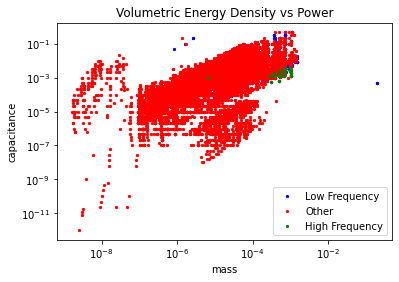

In [114]:
x = "mass"
y = "capacitance"
one = data_viz.loc[pd.notna(data_viz["esr_frequency_low"])].plot.scatter(x=x, y=y, label="Low Frequency", loglog=True, color="Blue", s=5, title='Volumetric Energy Density vs Power') 
data_viz.loc[pd.notna(data_viz["esr"]) & pd.isna(data_viz["esr_frequency"])].plot.scatter(x=x, y=y, label="Other", loglog=True, ax=one, color="Red", s=5)
data_viz.loc[pd.notna(data_viz["esr_frequency_high"])].plot.scatter(x=x, y=y, label="High Frequency", loglog=True, ax=one, color="Green", s=5)